## Imports

In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import shap
import seaborn as sns


## Input info

In [19]:
entity_flavor_molecules_name_reduced = pd.read_pickle('../data_discovery/processed/entity_flavor_molecules_name_reduced.pkl')
entity_flavor_profile_reduced = pd.read_pickle('../data_discovery/processed/entity_flavor_profile_reduced.pkl')
entity_functional_group_reduced = pd.read_pickle('../data_discovery/processed/entity_functional_group_reduced.pkl')
entity_nutrition_facts = pd.read_pickle('../data_discovery/processed/entity_nutrition_facts.pkl')

In [20]:
base_ingredients = pd.Series(pd.read_pickle('../data_discovery/processed/available_ingredients.pkl').index)
model = pd.read_pickle('../models/first_model.pkl')

In [65]:
# explainer
explainer = shap.TreeExplainer(model)

## Functions

In [21]:
def get_features_vector(ingredient_list):
    return pd.concat([
        entity_flavor_molecules_name_reduced.loc[ingredient_list].mean(), 
        entity_flavor_profile_reduced.loc[ingredient_list].mean(), 
        entity_functional_group_reduced.loc[ingredient_list].mean(),
        entity_nutrition_facts.loc[ingredient_list].mean()
    ])

In [22]:
def make_features_model_consumable_forSeries(features1, features2):
    features1['dummy_index'] = 'index'
    features2['dummy_index'] = 'index'
    product1_df = pd.DataFrame(features1).T
    product2_df = pd.DataFrame(features2).T
    model_consumable = product1_df.merge(product2_df, on='dummy_index').drop('dummy_index', axis=1) 
    return model_consumable

def make_features_model_consumable_forDf(features1, features2):
    features1['dummy_index'] = 'index'
    features2['dummy_index'] = 'index'
    product1_df = pd.DataFrame(features1).T
    product2_df = features2
    model_consumable = product1_df.merge(product2_df, on='dummy_index').drop('dummy_index', axis=1) 
    return model_consumable

In [23]:
def get_score(x_vals):
    result = model.predict_proba(x_vals)[:,1]
    return result

In [24]:
def get_ingredient_list_from_length(length, undesired_ingredients=[]):
    ingredient_list = base_ingredients[~(base_ingredients.isin(undesired_ingredients))].sample(length).to_list()
    return ingredient_list

In [25]:
def mutation2_procedure(children_list):
        if len(children_list) > 1: 
            r_num = np.random.randint(1, len(children_list))
            new_children_list = list(children_list).copy()
            new_children_list.pop(r_num)
        else:
            new_children_list = children_list.copy()
        return new_children_list

def mutations3_procedure(children_list, additional_undesired_ingredients):
        children_list = list(children_list)
        new_children_list = children_list + get_ingredient_list_from_length(1, children_list + additional_undesired_ingredients)
        return new_children_list

def mutation4_procedure(children_list, additional_undesired_ingredients):
        children_list = list(children_list)
        new_ingredient = get_ingredient_list_from_length(1, children_list + additional_undesired_ingredients)
        if len(children_list) > 1:
            r_num = np.random.randint(1, len(children_list))
            new_children_list = list(children_list).copy()
            new_children_list.pop(r_num)
        else: 
            new_children_list = children_list
        #print(type(new_children_list))
        #print(type(new_ingredient))
        #print()
        new_children_list = new_children_list + new_ingredient
        return new_children_list 

# Genetic Algorithm

In [250]:
def genetic_algorithm(
    product_to_develop=[], 
    undesired_ingredients=[], 
    initial_population_size=10000, 
    generations=100, 
    verbose=1, 
    show_gen_samples_nb=20,
    return_last_available_generation=False,
    population_sample=None
):    
    if population_sample is None:
        # Initial population
        if verbose >= 2:
            print(f'Initializing population with an initial size: {initial_population_size}')
        population = pd.DataFrame()
        random_number_ingredient_list = np.random.randint(2, 100, initial_population_size)
        population['lenght'] = random_number_ingredient_list
        population['ingredient_list'] = population['lenght'].apply(get_ingredient_list_from_length, undesired_ingredients=undesired_ingredients)

    else:
        print(f'Initializing population from the population_sample dataframe, an initial size of: {population_sample.shape[0]} is considered')
        population = population_sample
    proposal_features = population.ingredient_list.apply(get_features_vector)
    if verbose >= 2:
        print(f'Getting features...')
        
    product_to_develop_features = get_features_vector(product_to_develop)
    x_vals = make_features_model_consumable_forDf(product_to_develop_features, proposal_features)
    
    if verbose >= 2:
        print(f'Making initial prediction...')

    population['prediction'] = get_score(x_vals)

    population_gen = population.sort_values('prediction', ascending=False)
    
    result_list = []
    for gen in range(generations):
        try:
            # Which get to live (fittest) but some unfit aswell
            if verbose >= 2:
                print(f'Evaluating fitness...')
            living_number = int(initial_population_size*0.1)
            additional_living_number = int(living_number*.010)
            survivors = pd.concat([population_gen.head(living_number), population_gen.tail(additional_living_number)])

            # Which get to mate, (90% of the fittest) 
            if verbose >= 2:
                print(f'Selecting mates...')
            mating_number = int(living_number*0.9)
            survivors.loc[:, 'identifier'] = np.random.randint(0, living_number, survivors.shape[0])
            maters = survivors[survivors.identifier < mating_number].drop('identifier', axis=1)
            maters.loc[:, 'mating_loc'] = np.random.randint(0, maters.shape[0], maters.shape[0])
            maters['mate_ingredient_list'] = maters.mating_loc.apply(lambda x: list(maters.iloc[x].ingredient_list))
            maters['children_number'] = np.random.randint(1, 10, maters.shape[0])
            maters['ingredient_list'] = maters.ingredient_list.apply(list)

            #### Recombination
            # Add both ingredient lists (as a set)
            if verbose >= 2:
                print(f'Reproduction phase...')

            if verbose >= 2:
                print(f'Crossover is in progress: children are being created...')

            childrens_t1 = (maters.ingredient_list + maters.mate_ingredient_list).apply(lambda x: list(set(x)))

            #Keep first half and exchange second half
            childrens_t2 = maters.ingredient_list.apply(lambda x: x[:len(x)//2]) + maters.mate_ingredient_list.apply(lambda x: x[len(x)//2:])

            #Keep second half and exchange first half
            childrens_t3 = maters.ingredient_list.apply(lambda x: x[len(x)//2:]) + maters.mate_ingredient_list.apply(lambda x: x[:len(x)//2])

            # Add both ingredient lists (as a set)
            childrens_t4 = (maters.ingredient_list + maters.mate_ingredient_list).apply(
                lambda x: np.random.choice(
                    list(set(x)), 
                    np.random.randint(1, len(list(set(x))))
                )
            )

            childrens = pd.concat([childrens_t1, childrens_t2, childrens_t3, childrens_t4]).reset_index(drop=True)


            #### Mutations
            # No mutation
            if verbose >= 2:
                print(f'Including mutations into childrens...')

            mutations1 = childrens
            # Randomly delete an element from the childrens
            mutations2 = childrens.apply(lambda x: mutation2_procedure(x))

            # Randomly add an element from the childrens
            mutations3 = childrens.apply(mutations3_procedure, additional_undesired_ingredients=undesired_ingredients)

            # Randomly delete and add an element (different of the deletion) form the childrens
            mutations4 = childrens.apply(mutation4_procedure, additional_undesired_ingredients=undesired_ingredients)

            children_with_mutations = pd.concat([mutations1, mutations2, mutations3, mutations4]).reset_index(drop=True)
            children_with_mutations = children_with_mutations.apply(lambda x: list(set(x)))

            if verbose >= 2:
                print(f'Total of {children_with_mutations.shape[0]} distinct children were born.')

            new_population = pd.DataFrame()
            new_population['ingredient_list'] = children_with_mutations
            new_population['str_ingredient_list']  = new_population['ingredient_list'].astype('str')
            new_population = new_population.drop_duplicates('str_ingredient_list').drop('str_ingredient_list', axis=1)

            new_proposal_features = new_population.ingredient_list.apply(get_features_vector)

            new_x_vals = make_features_model_consumable_forDf(product_to_develop_features, new_proposal_features)
            new_population['prediction'] = get_score(new_x_vals)

            results = new_population.sort_values('prediction', ascending=False).head(3)
            results['generation'] = gen + 1
            result_list.append(results)

            if verbose >= 2:
                print(f'Results were saved')
            population_gen = new_population.sort_values('prediction', ascending=False)
            if verbose >= 1 :
                print(f'Generation: {gen + 1}')
        except:
            print('Something happened Process was manually (or by mistake) stopped... Fetching result list.')
            break
    final_results = pd.concat(result_list).sort_values('prediction', ascending=False)
    if return_last_available_generation:
        return final_results, population_gen
    return final_results

def process_results(results):
    r = results.copy()
    r.sort_values('prediction', inplace=True)
    max_pred_value = r.prediction.max()
    max_results_candidates = r[r.prediction==max_pred_value]
    max_results_candidates.loc[:,'entity_lenght'] = max_results_candidates.loc[:, 'ingredient_list'].apply(len)
    max_results_candidates[max_results_candidates.entity_lenght == max_results_candidates.entity_lenght.min()]
    max_results_candidates[max_results_candidates.generation == max_results_candidates.generation.min()]
    final_result = max_results_candidates.iloc[0]
    resume = {
        'ingredient_list': final_result.ingredient_list,
        'model_score': final_result.prediction
    }
    return resume

def explain_result(product_to_develop, proposed_product, explainer, max_display=20):
    # Get features
    product_to_develop_features = get_features_vector(product_to_develop)
    proposed_product_features = get_features_vector(proposed_product)
    
    # Join features into vector
    x_vals = make_features_model_consumable_forSeries(product_to_develop_features, proposed_product_features)
    
    # Score with model:
    score=get_score(x_vals)
    print('Model score: ', score)
    shap_values = explainer.shap_values(x_vals)[1]
    
    processed_shap_values = pd.DataFrame(shap_values, columns=x_vals.columns).abs().T.sort_values(0, ascending=False)
    processed_shap_values['shap_vals'] = pd.DataFrame(shap_values, columns=x_vals.columns).T.loc[processed_shap_values.index][0]

    top_features = pd.Series(processed_shap_values.head(max_display).index)
    x_or_y = top_features.str.split('_').apply(lambda x: x[-1]).value_counts(normalize=True)
    nutrition_features = pd.Series(entity_nutrition_facts.columns).str.split('_').apply(lambda x:x[0]).to_list()

    relevant_features = top_features.str.split('_').apply(lambda x: x[0])
    relevant_features.loc[relevant_features.isin(nutrition_features)] = 'nutrition'
    relevant_features.loc[relevant_features=='common'] = 'molecule_name'
    relevant_datasets = relevant_features.value_counts(normalize=True)

    relevant_features2 = relevant_features +'_' + relevant_features1.str.split('_').apply(lambda x: x[-1])
    relevant_datasets_x_or_y =  relevant_features2.value_counts(normalize=True)

    processed_shap_values = processed_shap_values.head(max_display)
    processed_shap_values.loc[processed_shap_values.shap_vals > 0, 'color'] = 'deeppink'
    processed_shap_values.loc[processed_shap_values.shap_vals <= 0, 'color'] = 'dodgerblue'
    plt.subplot(121)
    sns.barplot(y=processed_shap_values.index, x=processed_shap_values.shap_vals, palette=processed_shap_values.color, orient='h')
    plt.box(False)
    plt.xlabel('Valores Shap')
    plt.ylabel('Características más relevantes')
    plt.subplot(122)
    pie_results = relevant_datasets.to_dict()
    datasets_colors = {'nutrition': 'seagreen', 'flavor': 'lightsalmon', 'molecule_name': 'crimson', 'profile': 'slateblue'}
    colors=[datasets_colors.get(key) for key in pie_results.keys()]
    plt.pie(x=pie_results.values(), labels=pie_results.keys(), startangle=90, autopct='%1.1f%%', colors=colors)
    plt.show()
    return 

In [248]:
print([ing for ing in base_ingredients.to_list() if 'cheese' in ing.lower()])

['Blue Cheese', 'Camembert Cheese', 'Cheddar Cheese', 'Cheese', 'Comte Cheese', 'Cottage Cheese', 'Cream Cheese', 'Emmental Cheese', 'Feta Cheese', 'Goat Cheese', 'Gruyere Cheese', 'Limburger Cheese', 'Mozzarella Cheese', 'Munster Cheese', 'Parmesan Cheese', 'Provolone Cheese', 'Ricotta Cheese', 'Romano Cheese', 'Roquefort Cheese', 'Sheep Cheese', 'Swiss Cheese', 'Tilsit Cheese']


In [27]:
cheese_results = genetic_algorithm(
    product_to_develop=['Cheese'],
    undesired_ingredients=[ing for ing in base_ingredients.to_list() if 'cheese' in ing.lower()],
    generations=100,
    verbose=1,
    show_gen_samples_nb=3
)

Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
Generation: 20
Generation: 21
Generation: 22
Generation: 23
Generation: 24
Generation: 25
Generation: 26
Generation: 27
Generation: 28
Generation: 29
Generation: 30
Generation: 31
Generation: 32
Generation: 33
Generation: 34
Generation: 35
Generation: 36
Generation: 37
Generation: 38
Generation: 39
Generation: 40
Generation: 41
Generation: 42
Generation: 43
Generation: 44
Generation: 45
Generation: 46
Generation: 47
Generation: 48
Generation: 49
Generation: 50
Generation: 51
Generation: 52
Generation: 53
Generation: 54
Generation: 55
Generation: 56
Generation: 57
Generation: 58
Generation: 59
Generation: 60
Generation: 61
Generation: 62
Generation: 63
Generation: 64
Generation: 65
Generation: 66
Generation: 67
Gene

In [249]:
processed_cheese_results = process_results(cheese_results)
print(processed_cheese_results)

{'ingredient_list': ['Guinea hen', 'Pacific rockfish', 'Mutton', 'Cream', 'Roe', 'Swordfish', 'Cardamom', 'Milk Powder', 'Sage', 'Sapodilla', 'Margarine like spread', 'Coriander', 'Northern bluefin tuna', 'Rum', 'Raisin', 'Smoked Fish', 'Buttermilk', 'Cognac Brandy', 'Tomato', 'Tamarind', 'Lamb', 'Bonito'], 'model_score': 0.58}



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Model score:  [0.58]


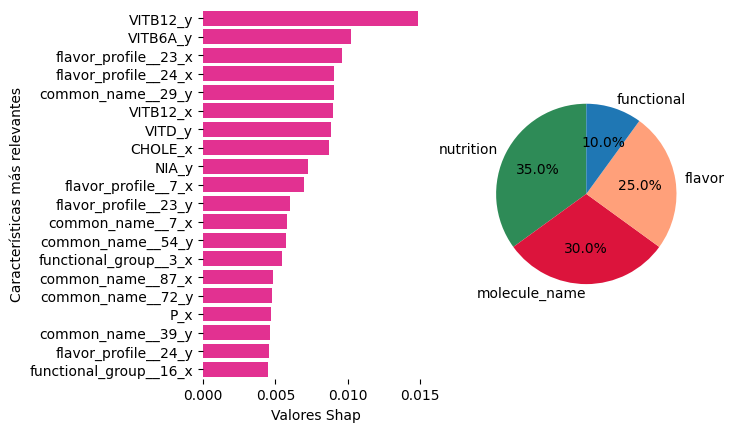

In [251]:
explain_result(['Cheese'], processed_cheese_results['ingredient_list'], explainer)

Model score:  [0.25]


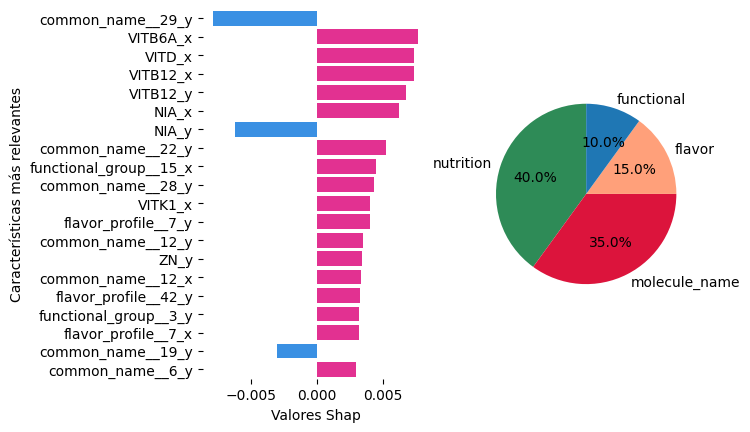

In [252]:
explain_result(processed_cheese_results['ingredient_list'], ['Cheese'], explainer)

In [255]:
print([ing for ing in base_ingredients.to_list() if ('milk' in ing.lower())])


['Buttermilk', 'Condensed milk', 'Evaporated milk', 'Goat Milk', 'Milk', 'Milk Fat', 'Milk Human', 'Milk Powder', 'Milkfish', 'Milkshake', 'Sheep Milk', 'Skimmed Milk', 'Soy milk']


In [45]:
milk_results, milk_gen = genetic_algorithm(
    product_to_develop=['Milk'],
    undesired_ingredients=[ing for ing in base_ingredients.to_list() if ('milk' in ing.lower())],
    generations=100,
    verbose=1,
    show_gen_samples_nb=3,
    return_last_available_generation=True
)

Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
Generation: 20
Generation: 21
Generation: 22
Generation: 23
Generation: 24
Generation: 25
Generation: 26
Generation: 27
Generation: 28
Generation: 29
Generation: 30
Generation: 31
Generation: 32
Generation: 33
Generation: 34
Generation: 35
Generation: 36
Generation: 37
Generation: 38
Generation: 39
Generation: 40
Generation: 41
Generation: 42
Generation: 43
Generation: 44
Generation: 45
Generation: 46
Generation: 47
Generation: 48
Generation: 49
Generation: 50
Generation: 51
Generation: 52
Generation: 53
Generation: 54
Generation: 55
Generation: 56
Generation: 57
Generation: 58
Generation: 59
Generation: 60
Generation: 61
Generation: 62
Generation: 63
Generation: 64
Generation: 65
Generation: 66
Generation: 67
Gene

In [240]:
milk_results_processed = process_results(milk_results)
milk_results_processed



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'ingredient_list': ['Salt', 'Rose hip', 'Cocoa'],
 'model_score': 0.6306666666666667}

Model score:  [0.63066667]


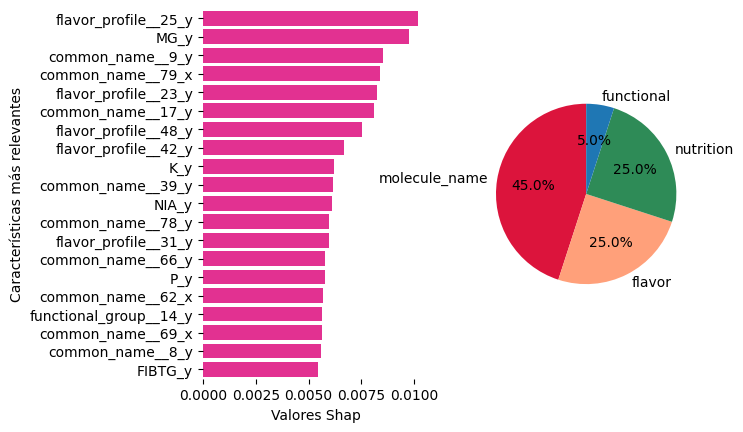

In [253]:
explain_result(['Milk'], milk_results_processed['ingredient_list'], explainer)

Model score:  [0.52883333]


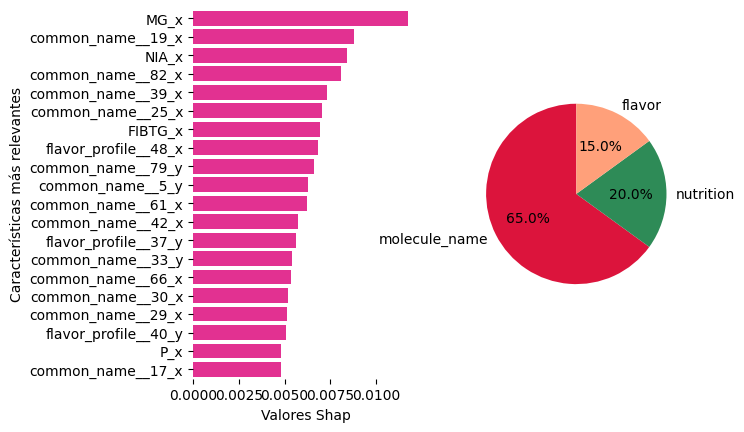

In [254]:
explain_result(milk_results_processed['ingredient_list'], ['Milk'], explainer)

In [49]:
yogurt_results, yogurt_gen = genetic_algorithm(
    product_to_develop=['Yogurt'],
    undesired_ingredients=[ing for ing in base_ingredients.to_list() if ('yogurt' in ing.lower())],
    generations=100,
    verbose=1,
    show_gen_samples_nb=3,
    return_last_available_generation=True
)

Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
Generation: 20
Generation: 21
Generation: 22
Generation: 23
Generation: 24
Generation: 25
Generation: 26
Generation: 27
Generation: 28
Generation: 29
Generation: 30
Generation: 31
Generation: 32
Generation: 33
Generation: 34
Generation: 35
Generation: 36
Generation: 37
Generation: 38
Generation: 39
Generation: 40
Generation: 41
Generation: 42
Generation: 43
Generation: 44
Generation: 45
Generation: 46
Generation: 47
Generation: 48
Generation: 49
Generation: 50
Generation: 51
Generation: 52
Generation: 53
Generation: 54
Generation: 55
Generation: 56
Generation: 57
Generation: 58
Generation: 59
Generation: 60
Generation: 61
Generation: 62
Generation: 63
Generation: 64
Generation: 65
Generation: 66
Generation: 67
Gene

In [242]:
yogurt_results_processed = process_results(yogurt_results)
yogurt_results_processed


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'ingredient_list': ['Loquat',
  'Strawberry',
  'Syrup',
  'Sugar',
  'Milk',
  'Barley',
  'Wild boar'],
 'model_score': 0.5615384615384615}

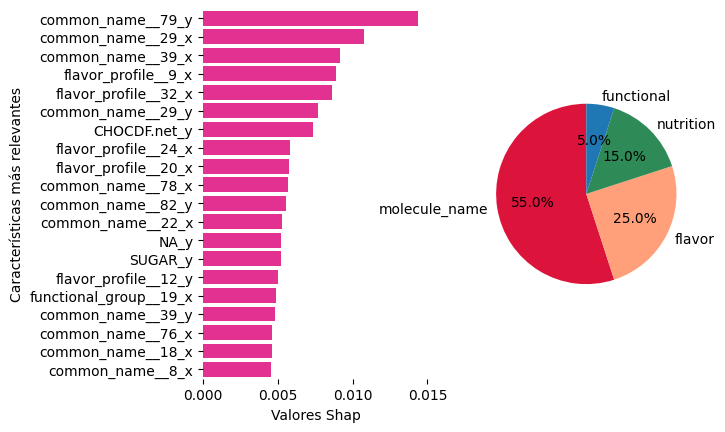

In [243]:
explain_result(['Yogurt'], yogurt_results_processed['ingredient_list'], explainer)

Model score:  [0.34]


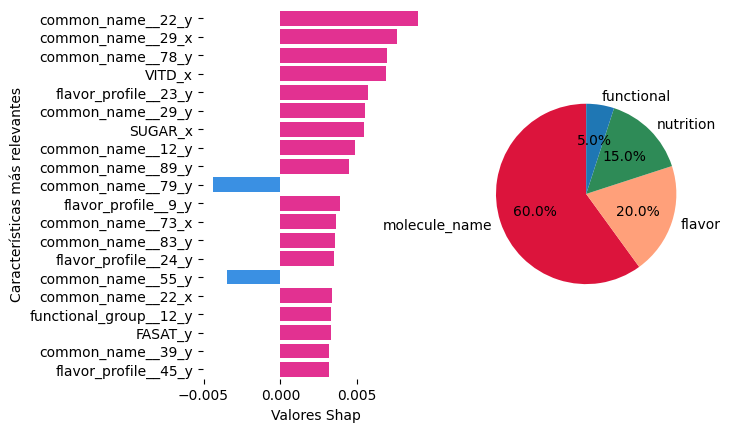

In [256]:
explain_result(yogurt_results_processed['ingredient_list'], ['Yogurt'], explainer)

In [57]:
butter_results, butter_gen = genetic_algorithm(
    product_to_develop=['Butter'],
    undesired_ingredients=[ing for ing in base_ingredients.to_list() if (('butter' in ing.lower()) or ('oil' in ing.lower()))],
    generations=100,
    verbose=1,
    show_gen_samples_nb=3,
    return_last_available_generation=True
)

Generation: 1
Generation: 2
Generation: 3
Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
Generation: 20
Generation: 21
Generation: 22
Generation: 23
Generation: 24
Generation: 25
Generation: 26
Generation: 27
Generation: 28
Generation: 29
Generation: 30
Generation: 31
Generation: 32
Generation: 33
Generation: 34
Generation: 35
Generation: 36
Generation: 37
Generation: 38
Generation: 39
Generation: 40
Generation: 41
Generation: 42
Generation: 43
Generation: 44
Generation: 45
Generation: 46
Generation: 47
Generation: 48
Generation: 49
Generation: 50
Generation: 51
Generation: 52
Generation: 53
Generation: 54
Generation: 55
Generation: 56
Generation: 57
Generation: 58
Generation: 59
Generation: 60
Generation: 61
Generation: 62
Generation: 63
Generation: 64
Generation: 65
Generation: 66
Generation: 67
Gene

In [260]:
print([ing for ing in base_ingredients.to_list() if (('butter' in ing.lower()) or ('oil' in ing.lower()))])

['American butterfish', 'Butter', 'Buttermilk', 'Butternut', 'Butternut squash', 'Canola Oil', 'Citrus Peel Oil', 'Cocoa butter', 'Cooking oil', 'Corn Oil', 'Fish Oil', 'Giant butterbur', 'Grapefruit Peel Oil', 'Lemon Peel Oil', 'Lime Peel Oil', 'Mustard Oil', 'Oil palm', 'Orange Oil', 'Peanut Butter', 'Peanut Oil', 'Soybean Oil']


In [261]:
butter_results_processed = process_results(butter_results)
print(butter_results_processed)

{'ingredient_list': ['Cognac Brandy', 'Drumstick Leaf', 'Oregano', 'Ghee', 'Filbert', 'Bearded seal', 'Corn chip'], 'model_score': 0.52}



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Model score:  [0.52]


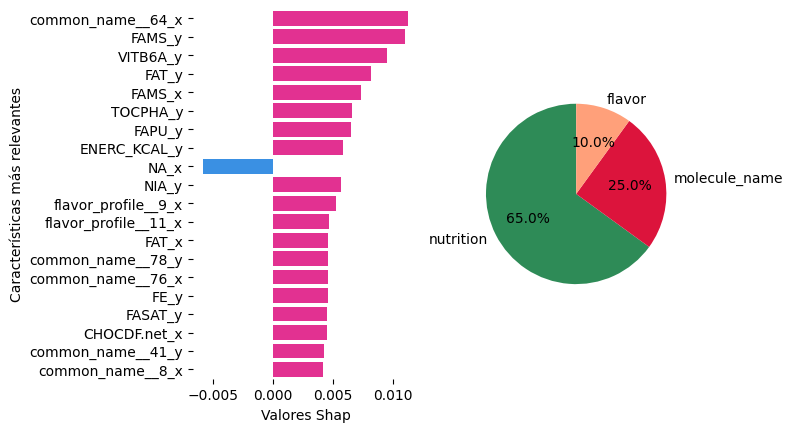

In [257]:
explain_result(['Butter'], butter_results_processed['ingredient_list'], explainer)

Model score:  [0.4]


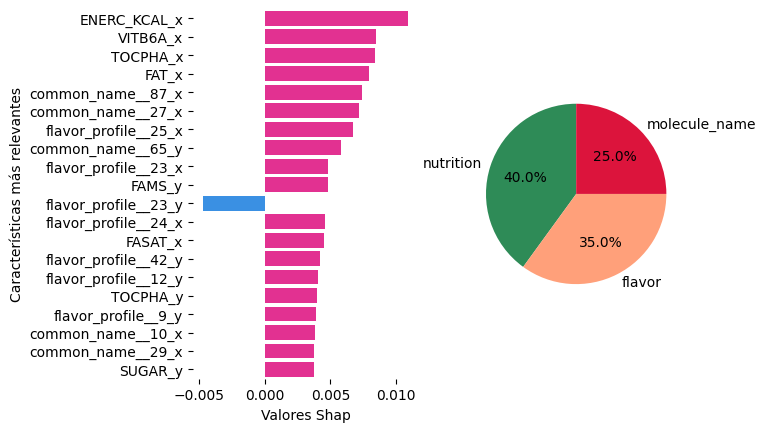

In [258]:
explain_result(butter_results_processed['ingredient_list'], ['Butter'], explainer)